### Download FashionMNIST Dataset and Create DataLoader

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

train_data = datasets.FashionMNIST(root='data',train= True, download=True, transform=ToTensor())
val_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))
print(images.shape, images.dtype, labels.shape, labels.dtype)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.68MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.72MB/s]


torch.Size([32, 1, 28, 28]) torch.float32 torch.Size([32]) torch.int64


### Create NetWork Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        # Use nn.Linear layers directly. Linear layers internally have learnable parameters such as weight and bias.
        # This also makes the model structure more flexible and easier to apply.
        self.linear_01 = nn.Linear(input_size * input_size, 200)
        self.linear_02 = nn.Linear(200, 100)
        self.linear_03 = nn.Linear(100, num_classes)

    # Forward pass: input tensor -> tensor processed through layers -> output tensor returned
    def forward(self, x):
        # Unlike nn.Flatten(), torch.flatten() defaults start_dim=0. Set start_dim=1 to preserve the batch dimension
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = F.relu(self.linear_01(x))
        x = F.relu(self.linear_02(x))
        output = self.linear_03(x)

        # Return the final tensor after passing through all layers
        return output

def create_simple_linear_model(input_size, num_classes=10):
    model = SimpleLinearModel(input_size=input_size, num_classes=num_classes)
    return model
    
INPUT_SIZE = 28
NUM_CLASSES = 10

model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)
print(model)


SimpleLinearModel(
  (linear_01): Linear(in_features=784, out_features=200, bias=True)
  (linear_02): Linear(in_features=200, out_features=100, bias=True)
  (linear_03): Linear(in_features=100, out_features=10, bias=True)
)



### Creating a Trainer Class for the Training Loop – Basic

* The `Trainer` class takes the model, loss function, optimizer, training DataLoader, validation DataLoader, and device as input arguments.
* Separate methods are defined for training (`train_epoch`) and validation (`valid_epoch`), and the `fit(epochs)` method repeatedly calls these methods for the specified number of epochs.
* `tqdm` is used to display a progress bar that updates with the batch-wise loss values.
* The loss values shown are **per-batch losses**; running average loss is **not displayed**.


In [3]:
from tqdm import tqdm

class Trainer_01:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self, epoch):
        self.model.train()
        # visualize the process 
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # Forward pass
                ouputs = self.model(inputs)
                loss = self.loss_fn(ouputs, targets)
               
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # show progress and batch loss values in tqdm progress_bar
                progress_bar.update(1)
                if batch_idx % 20 == 0:
                    progress_bar.set_postfix({"Batch Loss": loss.item()})
                if (batch_idx + 1) == len(self.train_loader):
                    progress_bar.set_postfix({"Batch Loss": loss.item()})

    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None

        self.model.eval()
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    outputs = self.model(inputs)

                    loss = self.loss_fn(outputs, targets)

                    progress_bar.update(1)
                    if batch_idx % 20 == 0:  # 20 batch횟수마다 update 
                        progress_bar.set_postfix({"Batch Loss": loss.item()})
                    if (batch_idx + 1) == len(self.train_loader):
                        progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    def fit(self, epochs):
        for epoch in range(epochs):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)

#### Trainer

In [4]:
from torch.optim import Adam

BATCH_SIZE = 32
INPUT_SIZE = 28

model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# create Trainer obj
trainer = Trainer_01(model=model, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader,
                 val_loader=val_loader, device=device)

# call fit() and implement train and evaluation by the number of epochs.
trainer.fit(epochs=10)

Epoch 10 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 298.07it/s, Batch Loss=0.243]


### Calculating Running Average Loss During Training and Validation Loops

* Display the average loss in the progress bar for each running batch. Compute it by dividing the cumulative running loss by the number of batches processed so far.


In [5]:
from tqdm import tqdm

class Trainer_02:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model.to(device)  # Move model to specified device
        self.loss_fn = loss_fn          # Loss function
        self.optimizer = optimizer      # Optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
    
    def train_epoch(self, epoch):
        self.model.train()  # Set model to training mode
        accu_loss = 0.0     # Accumulated loss
        running_avg_loss = 0.0  # Running average loss
        
        # Use tqdm to visualize real-time progress of training loop
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # Move input and target tensors to the correct device
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                # Backward pass
                self.optimizer.zero_grad()  # Clear previous gradients
                loss.backward()             # Compute gradients
                self.optimizer.step()       # Update model parameters

                # Compute running average loss for display
                accu_loss += loss.item()
                running_avg_loss = accu_loss / (batch_idx + 1)
                
                # Update tqdm progress bar with current running average loss
                progress_bar.update(1)
                if batch_idx % 20 == 0:  # Update display every 20 batches
                    progress_bar.set_postfix({"Loss": running_avg_loss})
                
        # Return final running average loss for the epoch    
        return running_avg_loss
                
    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None
            
        self.model.eval()  # Set model to evaluation mode

        accu_loss = 0  # Accumulated loss
        running_avg_loss = 0  # Running average loss
        
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():  # Disable gradient tracking for evaluation
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    # Move input and target tensors to the correct device
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    # Forward pass
                    outputs = self.model(inputs)
                    
                    # Compute loss (no backward step)
                    loss = self.loss_fn(outputs, targets)
                    
                    # Compute running average loss for display
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss / (batch_idx + 1)
                    
                    # Update tqdm progress bar with current running average loss
                    progress_bar.update(1)
                    if batch_idx % 20 == 0:  # Update display every 20 batches
                        progress_bar.set_postfix({"Loss": running_avg_loss})
        
        # Return final running average loss for validation    
        return running_avg_loss
    
    def fit(self, epochs):
        for epoch in range(epochs):
            # Perform training for one epoch
            train_loss = self.train_epoch(epoch)
            # Perform validation for one epoch
            val_loss = self.validate_epoch(epoch)
            # Print training and validation losses
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}", 
                  f", Val Loss: {val_loss:.4f}" if val_loss is not None else "")


In [6]:
from torch.optim import Adam

# Create a new model and optimizer instead of reusing previously trained ones
model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Initialize Trainer_02 with model, loss function, optimizer, and data loaders
trainer = Trainer_02(model=model, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader,
                     val_loader=val_loader, device=device)

# Call fit() to perform training and validation for the specified number of epochs
trainer.fit(epochs=10)


Epoch 1 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 295.47it/s, Loss=0.439]


Epoch 1/10, Train Loss: 0.5066 , Val Loss: 0.4368


Epoch 2 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 288.49it/s, Loss=0.397]


Epoch 2/10, Train Loss: 0.3684 , Val Loss: 0.3954


Epoch 3 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 294.61it/s, Loss=0.36]


Epoch 3/10, Train Loss: 0.3306 , Val Loss: 0.3584


Epoch 4 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 296.42it/s, Loss=0.354]


Epoch 4/10, Train Loss: 0.3076 , Val Loss: 0.3519


Epoch 5 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 294.04it/s, Loss=0.346]


Epoch 5/10, Train Loss: 0.2908 , Val Loss: 0.3425


Epoch 6 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 270.28it/s, Loss=0.35]


Epoch 6/10, Train Loss: 0.2754 , Val Loss: 0.3470


Epoch 7 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 289.16it/s, Loss=0.354]


Epoch 7/10, Train Loss: 0.2612 , Val Loss: 0.3507


Epoch 8 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 284.77it/s, Loss=0.343]


Epoch 8/10, Train Loss: 0.2498 , Val Loss: 0.3395


Epoch 9 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 289.41it/s, Loss=0.338]


Epoch 9/10, Train Loss: 0.2391 , Val Loss: 0.3348


Epoch 10 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 296.02it/s, Loss=0.339]

Epoch 10/10, Train Loss: 0.2304 , Val Loss: 0.3360


### Calculating Accuracy Metric in the Training Loop

* Compute the running average of accuracy alongside the loss for training and validation data.
* Calculate accuracy using the total number of samples and the cumulative count of correct predictions for each batch.
* Applying softmax is not necessary for predicted class values. The class with the highest logit value corresponds to the highest softmax value, so you can directly use `argmax()` on logits to get the predicted class.
* `logit.argmax()` == `logit.softmax().argmax()`
* Accuracy = total correct predictions / total samples


In [7]:
# Fetch a batch of images and labels from the training data
images, labels = next(iter(train_loader))

# Move model to CPU
model = model.to('cpu')

# Forward pass: feed images into the model, output shape is (batch_size, num_classes)
pred = model(images)
# print('pred:', pred)
print('pred shape:', pred.shape)

# The argmax of model output and argmax after applying softmax are identical
print('pred argmax_01:', pred.argmax(-1))
print('pred argmax_02:', F.softmax(pred, dim=-1).argmax(-1))
print(pred.argmax(-1).shape)

# Instead of argmax, using max(). torch.Tensor.max() returns both the max value and the index of the max value
max_value, max_index = pred.max(-1)
print('max_value:', max_value)
print('max_index:', max_index)


pred shape: torch.Size([32, 10])
pred argmax_01: tensor([0, 8, 3, 2, 3, 1, 6, 7, 0, 9, 8, 9, 8, 0, 0, 0, 2, 3, 3, 0, 1, 4, 9, 5,
        4, 5, 9, 6, 0, 6, 9, 7])
pred argmax_02: tensor([0, 8, 3, 2, 3, 1, 6, 7, 0, 9, 8, 9, 8, 0, 0, 0, 2, 3, 3, 0, 1, 4, 9, 5,
        4, 5, 9, 6, 0, 6, 9, 7])
torch.Size([32])
max_value: tensor([ 2.3037, 18.0564,  5.3632,  4.8817,  3.9278, 13.4132,  3.5926, 11.2466,
         8.7619,  9.5084,  7.7623, 11.0303,  8.4367,  7.9353,  7.1582,  8.4457,
         4.4598,  1.8075,  3.9406,  4.0833,  2.9047,  4.8359, 12.1662, 34.3142,
         2.6797, 11.9072, 14.1754,  3.0762, 13.3417,  2.4360, 10.4464,  5.2018],
       grad_fn=<MaxBackward0>)
max_index: tensor([0, 8, 3, 2, 3, 1, 6, 7, 0, 9, 8, 9, 8, 0, 0, 0, 2, 3, 3, 0, 1, 4, 9, 5,
        4, 5, 9, 6, 0, 6, 9, 7])


In [8]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model.to(device)  # Move model to specified device
        self.loss_fn = loss_fn          # Loss function
        self.optimizer = optimizer      # Optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
    
    def train_epoch(self, epoch):
        self.model.train()  # Set model to training mode
        
        # Initialize running loss and accuracy
        accu_loss = 0.0
        running_avg_loss = 0.0
        num_total = 0.0           # Total number of samples seen
        accu_num_correct = 0.0    # Total number of correct predictions
        accuracy = 0.0
        
        # Visualize training loop progress using tqdm
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                inputs = inputs.to(self.device)   # Move input batch to device
                targets = targets.to(self.device) # Move target batch to device
                
                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update running average loss
                accu_loss += loss.item()
                running_avg_loss = accu_loss /(batch_idx + 1)

                # Compute accuracy
                num_correct = (outputs.argmax(-1) == targets).sum().item()  # Compare predicted vs true labels
                num_total += inputs.shape[0]
                accu_num_correct += num_correct
                accuracy = accu_num_correct / num_total

                # Update tqdm progress bar with running loss and accuracy
                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                    progress_bar.set_postfix({"Loss": running_avg_loss, "Accuracy": accuracy})
        
        return running_avg_loss, accuracy
                
    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None
            
        self.model.eval()  # Set model to evaluation mode

        accu_loss = 0
        running_avg_loss = 0
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        
        # Visualize validation loop progress using tqdm
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():  # Disable gradient tracking
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    outputs = self.model(inputs)
                    loss = self.loss_fn(outputs, targets)
                    
                    # Update running average loss
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)

                    # Compute accuracy
                    num_correct = (outputs.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    accuracy = accu_num_correct / num_total

                    # Update tqdm progress bar with running loss and accuracy
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Loss": running_avg_loss, "Accuracy": accuracy})
        
        return running_avg_loss, accuracy
    
    def fit(self, epochs):
        # Create history dictionary to store train/validation results per epoch
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}" if val_loss is not None else "")
            
            # Store results in history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
        return history 
    
    # Return the trained model
    def get_trained_model(self):
        return self.model


In [9]:
from torch.optim import Adam

model = create_simple_linear_model(input_size=INPUT_SIZE, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader,
                 val_loader=val_loader, device=device)

# # This time, it will be increased to 20 times for learning and evaluation. Overfit check
history = trainer.fit(20)

Epoch 1 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 297.14it/s, Loss=0.467, Accuracy=0.826]


Epoch 1/20, Train Loss: 0.5065 Train Accuracy: 0.8165 , Val Loss: 0.4672 Val Accuracy: 0.8262


Epoch 2 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 290.29it/s, Loss=0.387, Accuracy=0.862]


Epoch 2/20, Train Loss: 0.3659 Train Accuracy: 0.8663 , Val Loss: 0.3870 Val Accuracy: 0.8623


Epoch 3 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 288.11it/s, Loss=0.355, Accuracy=0.87]


Epoch 3/20, Train Loss: 0.3282 Train Accuracy: 0.8782 , Val Loss: 0.3552 Val Accuracy: 0.8697


Epoch 4 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 267.35it/s, Loss=0.367, Accuracy=0.869]


Epoch 4/20, Train Loss: 0.3043 Train Accuracy: 0.8869 , Val Loss: 0.3671 Val Accuracy: 0.8692


Epoch 5 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 287.86it/s, Loss=0.35, Accuracy=0.873]


Epoch 5/20, Train Loss: 0.2861 Train Accuracy: 0.8927 , Val Loss: 0.3502 Val Accuracy: 0.8733


Epoch 6 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 280.36it/s, Loss=0.34, Accuracy=0.878]


Epoch 6/20, Train Loss: 0.2712 Train Accuracy: 0.8976 , Val Loss: 0.3402 Val Accuracy: 0.8776


Epoch 7 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 265.64it/s, Loss=0.332, Accuracy=0.881]


Epoch 7/20, Train Loss: 0.2574 Train Accuracy: 0.9031 , Val Loss: 0.3322 Val Accuracy: 0.8807


Epoch 8 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 276.39it/s, Loss=0.326, Accuracy=0.887]


Epoch 8/20, Train Loss: 0.2493 Train Accuracy: 0.9050 , Val Loss: 0.3260 Val Accuracy: 0.8867


Epoch 9 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 286.16it/s, Loss=0.321, Accuracy=0.888]


Epoch 9/20, Train Loss: 0.2355 Train Accuracy: 0.9117 , Val Loss: 0.3206 Val Accuracy: 0.8879


Epoch 10 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 280.85it/s, Loss=0.344, Accuracy=0.882]


Epoch 10/20, Train Loss: 0.2253 Train Accuracy: 0.9133 , Val Loss: 0.3442 Val Accuracy: 0.8824


Epoch 11 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 269.36it/s, Loss=0.34, Accuracy=0.887]


Epoch 11/20, Train Loss: 0.2201 Train Accuracy: 0.9155 , Val Loss: 0.3404 Val Accuracy: 0.8868


Epoch 12 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 276.48it/s, Loss=0.328, Accuracy=0.889]


Epoch 12/20, Train Loss: 0.2078 Train Accuracy: 0.9206 , Val Loss: 0.3284 Val Accuracy: 0.8889


Epoch 13 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 277.06it/s, Loss=0.332, Accuracy=0.891]


Epoch 13/20, Train Loss: 0.2055 Train Accuracy: 0.9222 , Val Loss: 0.3321 Val Accuracy: 0.8912


Epoch 14 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 280.01it/s, Loss=0.355, Accuracy=0.885]


Epoch 14/20, Train Loss: 0.1957 Train Accuracy: 0.9251 , Val Loss: 0.3552 Val Accuracy: 0.8853


Epoch 15 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 281.55it/s, Loss=0.345, Accuracy=0.885]


Epoch 15/20, Train Loss: 0.1911 Train Accuracy: 0.9268 , Val Loss: 0.3454 Val Accuracy: 0.8846


Epoch 16 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 285.77it/s, Loss=0.342, Accuracy=0.89]


Epoch 16/20, Train Loss: 0.1844 Train Accuracy: 0.9294 , Val Loss: 0.3418 Val Accuracy: 0.8899


Epoch 17 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 283.11it/s, Loss=0.357, Accuracy=0.891]


Epoch 17/20, Train Loss: 0.1791 Train Accuracy: 0.9315 , Val Loss: 0.3573 Val Accuracy: 0.8909


Epoch 18 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 281.61it/s, Loss=0.378, Accuracy=0.885]


Epoch 18/20, Train Loss: 0.1732 Train Accuracy: 0.9337 , Val Loss: 0.3776 Val Accuracy: 0.8846


Epoch 19 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 282.34it/s, Loss=0.349, Accuracy=0.888]


Epoch 19/20, Train Loss: 0.1709 Train Accuracy: 0.9348 , Val Loss: 0.3488 Val Accuracy: 0.8881


Epoch 20 [Validating]: 100%|██████████| 313/313 [00:01<00:00, 286.97it/s, Loss=0.377, Accuracy=0.889]

Epoch 20/20, Train Loss: 0.1649 Train Accuracy: 0.9364 , Val Loss: 0.3766 Val Accuracy: 0.8891


### Visualizing Training/Validation Loss and Accuracy per Epoch

* After running `trainer.fit()`, use the returned `history` dictionary to visualize the results.


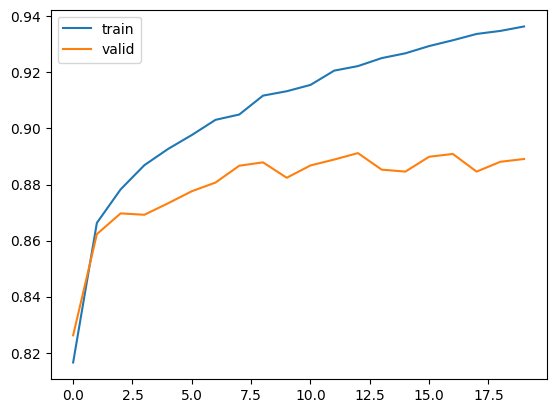

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history, metric='acc'):
    if metric == 'loss':
        train_metric_name = 'train_loss'
        val_metric_name = 'val_loss'
    else:
        train_metric_name = 'train_acc'
        val_metric_name = 'val_acc'
        
    plt.plot(history[train_metric_name], label='train')
    plt.plot(history[val_metric_name], label='valid')
    plt.legend()
    
#show_history(history, metric='loss')
show_history(history, metric='acc')

### Creating the Predictor Class

* Input data must be a tensor and should use the same normalization values as the training data.
* Create methods: `evaluate()`, `predict_proba()`, and `predict()`.
* `evaluate()` performs performance evaluation on the entire test image tensor dataset.
* `predict_proba()` calculates class-wise prediction probabilities for input image tensors (including single image tensors).
* `predict()` predicts the class labels for input image tensors (including single image tensors).


*This is an inference-only class that loads a trained model and returns predictions (class, probabilities, etc.) for new input data.*

*✅ Why do we need a separate class?*
*The `Trainer` class is used during training (training + validation).*

*In contrast, the `Predictor` class is used after training, when you want to input data and only get predictions.*

*Separating the code makes it cleaner, more reusable, and easier to debug.*


In [11]:
class Predictor:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        eval_metric = 0.0
        num_total = 0.0
        acc_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    acc_num_correct += num_correct
                    eval_metric = acc_num_correct/num_total
                    
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            pred_proba = F.softmax(outputs, -1)
        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        # pred_proba.shape (32, 10)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [12]:
trained_model = trainer.get_trained_model()

BATCH_SIZE = 32

test_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 291.00it/s, Accuracy=0.889]

test dataset evaluation:0.8891


In [13]:
images, labels = next(iter(test_loader))
print(images.shape)
preds = predictor.predict(images)
print('predicted:', preds,'\nreal labels:', labels)

torch.Size([32, 1, 28, 28])
predicted: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 6, 9, 6, 8, 8]) 
real labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


In [14]:
pred_probas = predictor.predict_proba(images)
print(pred_probas)
print(pred_probas.shape)

tensor([[2.4511e-12, 7.9147e-10, 1.1932e-11, 1.8031e-12, 8.7042e-13, 3.9632e-05,
         4.2693e-13, 1.5968e-04, 2.4749e-12, 9.9980e-01],
        [1.3126e-05, 3.9956e-18, 9.9997e-01, 2.2464e-12, 6.4888e-06, 1.7677e-21,
         7.9346e-06, 4.2231e-25, 2.2550e-15, 6.5461e-24],
        [7.1918e-19, 1.0000e+00, 8.7124e-23, 1.2894e-15, 1.1125e-21, 4.1585e-24,
         3.4260e-16, 0.0000e+00, 1.4556e-28, 3.6931e-35],
        [2.7867e-15, 1.0000e+00, 2.2502e-19, 2.2892e-12, 2.4224e-18, 8.6391e-18,
         2.2677e-13, 9.8081e-37, 7.6451e-23, 2.3011e-27],
        [3.1998e-01, 1.5550e-08, 3.6784e-02, 6.0716e-05, 6.9377e-04, 2.0735e-11,
         6.4248e-01, 2.6143e-11, 1.6509e-06, 9.9645e-10],
        [9.0612e-12, 1.0000e+00, 2.3350e-16, 2.9069e-12, 9.1500e-19, 1.0770e-20,
         1.4089e-10, 2.6903e-39, 5.6269e-21, 1.3946e-28],
        [7.0464e-17, 2.2034e-26, 1.0727e-08, 4.2764e-21, 1.0000e+00, 5.4259e-30,
         5.7798e-09, 2.2642e-35, 2.5879e-25, 9.4698e-33],
        [1.5456e-10, 5.2783

#### predict single image

In [15]:
test_data_pil = datasets.FashionMNIST(root='data',train= False, download=True)
test_data_pil[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

Text(0.5, 1.0, 'Ankle boot: 9')

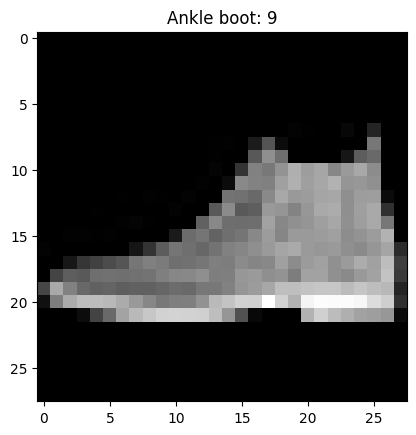

In [16]:
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.imshow(test_data_pil[0][0], cmap='gray')
plt.title(f'{class_names[test_data_pil[0][1]]}: {test_data_pil[0][1]}')

In [17]:
from torchvision.transforms import ToTensor

# PIL image to tensor 
transform = ToTensor()
input_tensor = transform(test_data_pil[0][0])
print(type(input_tensor), input_tensor.shape)

<class 'torch.Tensor'> torch.Size([1, 28, 28])


In [18]:
input_tensor.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [19]:

print(input_tensor.unsqueeze(0).shape)
pred = predictor.predict(input_tensor.unsqueeze(0))
print(pred.item())
print(pred.cpu().numpy())

torch.Size([1, 1, 28, 28])
9
[9]


### Saving and Loading Models

* There are two main approaches: saving/loading both the model architecture and parameters, or saving/loading only the parameters.

* **Saving/Loading the entire model**

  * A trained model (in memory) can be saved to a file using `torch.save(model, PATH)`.
  * A saved model file can be loaded back into memory with `torch.load(PATH)`.

* **Saving/Loading only the parameters**

  * Call `model.state_dict()` and save it using `torch.save(model.state_dict(), PATH)` to store only the parameters.
  * To load, first create the same model architecture (untrained), then use `model.load_state_dict()` to load the saved parameters.

* It is generally recommended to save/load only the parameters rather than the full model. Differences in PyTorch versions may cause the full model to fail loading. Additionally, parameter-only files are smaller, and the saved parameters can be reused in modified architectures with additional layers.


In [20]:
trained_model = trainer.get_trained_model()

checkpoint_filepath_01 = '/kaggle/working/checkpoint_01.pt'
# save the entire model
torch.save(trained_model, checkpoint_filepath_01)

In [21]:
restored_model_01 = torch.load(checkpoint_filepath_01, weights_only=False)

In [22]:
BATCH_SIZE = 32
test_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


predictor = Predictor(model=restored_model_01, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 272.98it/s, Accuracy=0.889]

test dataset evaluation:0.8891


In [23]:
checkpoint_filepath_02 = '/kaggle/working/checkpoint_02.pt'
# save only parameters 
torch.save(trained_model.state_dict(), checkpoint_filepath_02)

In [24]:
# Extract only the parameters from the checkpoint file
state_dict = torch.load(checkpoint_filepath_02, weights_only=True)

# Create a new model with untrained weights
restored_model_02 = create_simple_linear_model(input_size=28, num_classes=10)

# Load the parameters into the new model
restored_model_02.load_state_dict(state_dict)

# Set the restored model to evaluation mode (if needed)
# restored_model_02.eval()


<All keys matched successfully>

In [25]:
BATCH_SIZE = 32
test_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

predictor = Predictor(model=restored_model_02, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 291.09it/s, Accuracy=0.889]

test dataset evaluation:0.8891
